In [1]:
import copy
import torch
import numpy as np
import copy
import os
os.sys.path.append('../')
from rotm2euler import *
from experiment_utils import *
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import collections as mc
import pdb

## Input Data

In [2]:
### get pair id
pair_path = '/viscompfs/users/sawang/ScanNet/pair_list.txt'
f = open(pair_path)
lines = f.readlines()
lines[9995:10000]

['scene0001_01 1190-1200-1213 \n',
 'scene0001_01 1190-1201-1211 \n',
 'scene0001_01 1190-1202-1212 \n',
 'scene0001_01 1190-1203-1217 \n',
 'scene0001_01 1192-1204-1217 \n']

In [3]:
def input_data(tgt_id, src0_id, src1_id, dataset_dir, gt_dir, H, W):
    data_dict = dict()
    image = cv2.imread(os.path.join(dataset_dir, scene, 'color', str(tgt_id) + ".jpg"))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ori_H, ori_W, _ = image.shape
    image = cv2.resize(image, (320, 240))
    data_dict['tgt_RGB'] = image

    image = cv2.imread(os.path.join(dataset_dir, scene, 'color', str(src0_id) + ".jpg"))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (320, 240))
    data_dict['src0_RGB'] = image

    image = cv2.imread(os.path.join(dataset_dir, scene, 'color', str(src1_id) + ".jpg"))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (320, 240))
    data_dict['src1_RGB'] = image

    image = cv2.imread(os.path.join(gt_dir, scene, 'depth_interp', str(tgt_id) + ".png"), cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (320, 240))
    data_dict['depth'] = image / 1000

    #image = cv2.imread(os.path.join('/viscompfs/users/sawang/testnormal_2.png'), cv2.IMREAD_UNCHANGED)
    #image = cv2.resize(image, (320, 240)) / 255
    #image = unplot_normal(image)
    #data_dict['tgt_norm'] = image
    image = cv2.imread(os.path.join('/viscompfs/users/sawang/normal_sample/testnormal_2.png'), cv2.IMREAD_UNCHANGED)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (320, 240)) / 255
    image = unplot_normal(image)
    data_dict['tgt_norm'] = image

    image = cv2.imread(os.path.join('/viscompfs/users/sawang/normal_sample/testnormal_1.png'), cv2.IMREAD_UNCHANGED)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (320, 240)) / 255
    image = unplot_normal(image)
    data_dict['src0_norm'] = image

    image = cv2.imread(os.path.join('/viscompfs/users/sawang/normal_sample/testnormal_3.png'), cv2.IMREAD_UNCHANGED)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (320, 240)) / 255
    image = unplot_normal(image)
    data_dict['src1_norm'] = image

    mat = np.loadtxt(os.path.join(dataset_dir, scene, 'intrinsic', 'intrinsic_color.txt'))
    scale_x, scale_y = H / ori_H, W / ori_W
    mat[0, 0], mat[0, 2] = mat[0, 0] * scale_x, mat[0, 2] * scale_x
    mat[1, 1], mat[1, 2] = mat[1, 1] * scale_y, mat[1, 2] * scale_y
    data_dict['K'] = mat
    print("intrinsic: \n", mat)

    mat = np.loadtxt(os.path.join(dataset_dir, scene, 'intrinsic', 'intrinsic_depth.txt'))
    scale_x, scale_y = H / ori_H, W / ori_W
    mat[0, 0], mat[0, 2] = mat[0, 0] * scale_x, mat[0, 2] * scale_x
    mat[1, 1], mat[1, 2] = mat[1, 1] * scale_y, mat[1, 2] * scale_y
    data_dict['K_d'] = mat
    print("intrinsic (depth): \n", mat)

    pose_path = '/viscompfs/users/sawang/ScanNet/data_pose/' + scene + '.txt'
    f = open(pose_path)
    pose_all = f.readlines()

    for p in pose_all:
        char = p.split(" ")
        if char[0] == str(tgt_id) and char[1] == str(src1_id):
            data_dict['pose1'] = untransform(np.array([float(c.replace(",", "")) for c in char[2:]]))
            print("pose1: \n", data_dict['pose1'])
        elif char[0] == str(src0_id) and char[1] == str(tgt_id):
            tmp = np.array([float(c.replace(",", "")) for c in char[2:]])
            tmp = untransform(tmp)
            pose_inv = inversePose(tmp)
            data_dict['pose0'] = pose_inv
            print("pose0: \n", data_dict['pose0'])
    return data_dict

In [4]:
tgt_id, src0_id, src1_id = 1200, 1190, 1213
H, W = 240, 320
scene = 'scene0001_01'
dataset_dir = '/viscompfs/users/sawang/ScanNet/data/scans/'
gt_dir = '/viscompfs/users/sawang/ScanNet/data_gt/'

data = input_data(tgt_id, src0_id, src1_id, dataset_dir, gt_dir, H, W)

intrinsic: 
 [[290.12925322   0.         160.59917355   0.        ]
 [  0.         288.93530568 119.44444444   0.        ]
 [  0.           0.           1.           0.        ]
 [  0.           0.           0.           1.        ]]
intrinsic (depth): 
 [[143.27370372   0.          79.21487603   0.        ]
 [  0.         142.6841      59.13580247   0.        ]
 [  0.           0.           1.           0.        ]
 [  0.           0.           0.           1.        ]]
pose0: 
 [[ 0.99720706 -0.01383514 -0.07339395  0.02787871]
 [ 0.00892915  0.99772935 -0.06675639 -0.09059185]
 [ 0.07415088  0.06591459  0.99506629  0.13103101]
 [ 0.          0.          0.          1.        ]]
pose1: 
 [[ 0.99900703 -0.03768448 -0.0237662   0.050552  ]
 [ 0.03849179  0.99866389  0.03447915  0.089673  ]
 [ 0.02243512 -0.03535972  0.99912279 -0.182378  ]
 [ 0.          0.          0.          1.        ]]


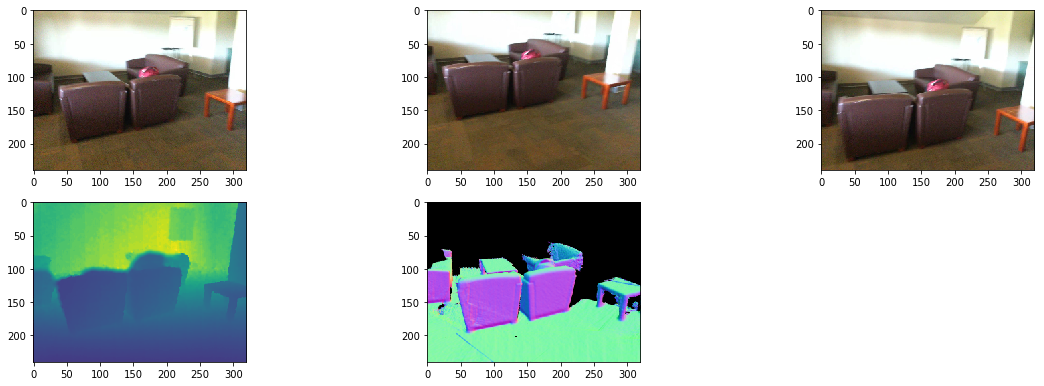

In [5]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(3, 3, 1)
ax.imshow(data['tgt_RGB'])
ax = fig.add_subplot(3, 3, 2)
ax.imshow(data['src0_RGB'])
ax = fig.add_subplot(3, 3, 3)
ax.imshow(data['src1_RGB'])
ax = fig.add_subplot(3, 3, 4)
ax.imshow(data['depth'])
ax = fig.add_subplot(3, 3, 5)
ax.imshow(plot_normal(data['tgt_norm']))

## Check `sample_tgt_intensities`

In [6]:
def sample_tgt_intensities(tgt_img, patch_size):
    tgt_intensities = tgt_img.unfold(2, patch_size, 1).unfold(3, patch_size, 1)
    return tgt_intensities 

In [7]:
def check_sample_tgt_intensities(loc, data, patch_size):
    x, y = loc
    tgt_img = np.tile(np.expand_dims(data['tgt_RGB'], 0), [4, 1, 1, 1])
    print('tgt_img shape: ', tgt_img.shape)
    print('patch_size: ', patch_size)
    
    ## check sample_tgt_intensity
    offset = int((patch_size - 1) / 2)
    tgt_img = tgt_img.transpose((0, 3, 1, 2))
    tgt_img_ten = torch.from_numpy(tgt_img)
    intensities = sample_tgt_intensities(tgt_img_ten, patch_size)
    intensities = intensities.numpy().transpose((0, 2, 3, 4, 5, 1))
    print(intensities.shape)
    our_patch = intensities[0, y - offset, x - offset]
    
    ## get gt patch intensity
    x_s, x_e = x - offset, x + offset
    y_s, y_e = y - offset, y + offset

    gt_patch = data['tgt_RGB'][y_s: y_e+1, x_s:x_e+1]
    
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(our_patch)
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(gt_patch)
    
    print("Difference (should be zero): ", np.sum(gt_patch - our_patch))

tgt_img shape:  (4, 240, 320, 3)
patch_size:  7
(4, 234, 314, 7, 7, 3)
Difference (should be zero):  0


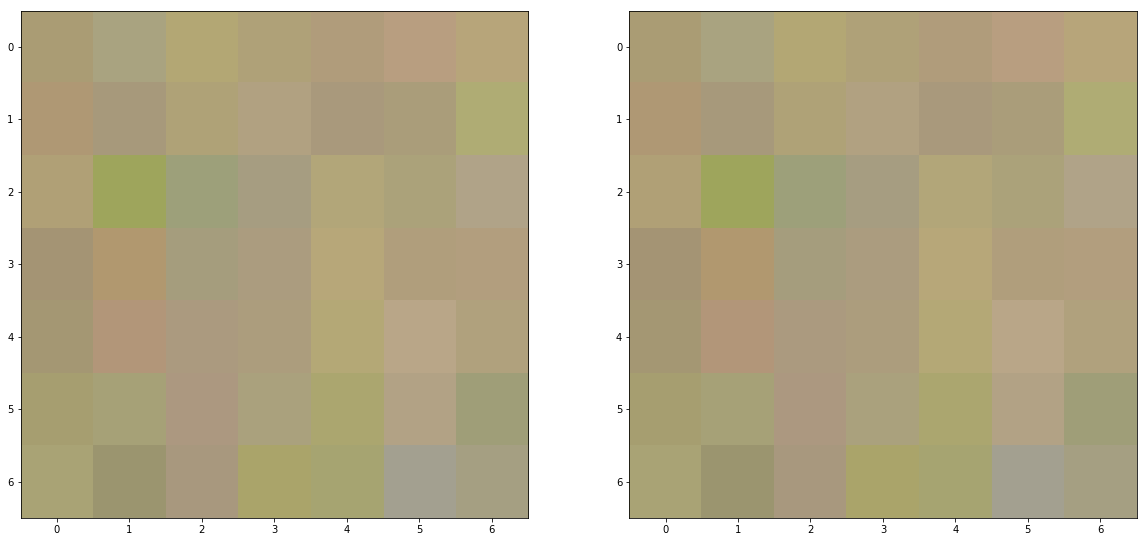

In [8]:
check_sample_tgt_intensities([5, 5], data, patch_size = 7)

## Check `compute_homography()`:

In [9]:
from experiment_utils import untransform

In [10]:
def calculate_homography(pose, K, pred_norm, cam_coords):
    B, _, H, W = pred_norm.shape

    # compute d = - (nx*x + ny*y + nz*z), [B, 1, H, W]
    d = torch.sum(pred_norm * cam_coords, dim=1, keepdim=True) * -1

    # construct homography matrix H = (R - tn^T/d), [B, 3, H, W]
    scaled_norm = pred_norm / d 

    R = pose[:, :3, :3].view(B, 3, 3)
    t = pose[:, :3, 3].view(B, 3)
    R = torch.unsqueeze(torch.unsqueeze(R, -1), -1) # [B, 3, 3, 1, 1]
    R = R.repeat(1, 1, 1, H, W)
    
    # outer product: outer[m, q, n, p, r] = t[m, q] * scaled_norm[m, n, p, r]
    outer = torch.einsum('mq, mnpr -> mqnpr', t, scaled_norm)
    H = R - outer # [B, 3, 3, H, W]

    # pre-multiply with K, H = K(R - tn^T/d)
    H = torch.einsum('bcd, bdehw -> bcehw', K, H)

    return H

In [11]:
def homogenize(pts):
    ones = np.ones_like(pts[:, :, 0])
    return np.dstack((pts, ones))

def compute_homography_numpy(pose, intrinsics, pred_norm, pred_depth):
    R, t = pose[:3 ,:3], pose[:3, 3]
    K = intrinsics[:3, :3]
    K_inv = np.linalg.inv(K)
    
    H, W = 240, 320
    meshgrid = np.dstack(np.meshgrid(range(W), range(H)))
    meshgrid = homogenize(meshgrid).reshape((-1, 3))
    meshgrid = np.transpose(meshgrid, (1, 0))  
    
    norm = pred_norm.reshape((-1, 3)).T   ### (3, N)
    depth = pred_depth.reshape((1, -1))  ### (1, N)
    cam_coord = depth * np.dot(K_inv, meshgrid)
    d = np.sum(np.multiply(norm, cam_coord), axis=0)* -1
    
    t = t.reshape((3, -1))
    t = np.tile(t, (1, H * W))
    R = R[:, :, np.newaxis]
    R = np.tile(R, (1, 1, H * W))
    
    term = np.einsum('in,jn->ijn', t, norm / d)
    Homo = (R - term)
    Homo = np.einsum('ij,jkm->ikm', K, Homo)
    Homo = Homo.reshape((3, 3, H, W)).transpose((2, 3, 0, 1))
    
    return Homo

In [12]:
def check_compute_homography(data):
    H, W = 240, 320
    ## numpy version
    gt_H = compute_homography_numpy(data['pose0'], data['K'], data['tgt_norm'], data['depth'])
    
    meshgrid = np.dstack(np.meshgrid(range(W), range(H)))
    meshgrid = homogenize(meshgrid).reshape((-1, 3))
    meshgrid = np.transpose(meshgrid, (1, 0))
    K_inv = np.linalg.inv(data['K'][:3, :3])
    cam_coord = data['depth'].reshape((1, -1)) * (K_inv @ meshgrid)  ## (3, H * W)
    cam_coord = cam_coord.T.reshape((H, W, 3)).astype(np.float32).transpose((2, 0, 1))
    cam_coord_ten = torch.from_numpy(cam_coord[np.newaxis, :, :, :])
    
    
    normal = torch.from_numpy(data['tgt_norm'][np.newaxis, :, :, :].astype(np.float32).transpose((0, 3, 1, 2)))
    depth = torch.from_numpy(data['depth'][np.newaxis, :, :, np.newaxis].astype(np.float32).transpose((0, 3, 1, 2)))
    pose = torch.from_numpy(data['pose0'][np.newaxis, :, :].astype(np.float32))
    intrinsics = torch.from_numpy(data['K'][np.newaxis, :3, :3].astype(np.float32))
         
    our_H = calculate_homography(pose, intrinsics, normal, cam_coord_ten)
    our_H = our_H.numpy().transpose((0, 3, 4, 1, 2))

    return gt_H, our_H[0]

In [13]:
gt_H, our_H_result = check_compute_homography(data)

In [14]:
loc = np.array([[25, 150, 300],
                [155, 89, 73]])

print('gt pt1: \n', gt_H[loc[1, 0], loc[0, 0]])
print('our pt1: \n', our_H_result[loc[1, 0], loc[0, 0]])

print('gt pt2: \n', gt_H[loc[1, 1], loc[0, 1]])
print('our pt2: \n', our_H_result[loc[1, 1], loc[0, 1]])

print('gt pt3: \n', gt_H[loc[1, 2], loc[0, 2]])
print('our pt3: \n', our_H_result[loc[1, 2], loc[0, 2]])

gt pt1: 
 [[2.94887263e+02 1.29120963e+01 1.44853338e+02]
 [1.37273495e+01 2.93861875e+02 9.72763708e+01]
 [4.56333837e-02 9.44320905e-02 1.02358378e+00]]
our pt1: 
 [[2.9488724e+02 1.2912095e+01 1.4485333e+02]
 [1.3727350e+01 2.9386188e+02 9.7276367e+01]
 [4.5633387e-02 9.4432086e-02 1.0235838e+00]]
gt pt2: 
 [[3.16533775e+02 3.08344551e+00 1.46130628e+02]
 [5.90728055e+00 2.97412596e+02 9.68149339e+01]
 [1.42996214e-01 5.02242620e-02 1.02932885e+00]]
our pt2: 
 [[3.1653378e+02 3.0834451e+00 1.4613062e+02]
 [5.9072800e+00 2.9741263e+02 9.6814934e+01]
 [1.4299622e-01 5.0224259e-02 1.0293288e+00]]
gt pt3: 
 [[ 2.74473798e+02  3.33255612e+01  1.65266803e+02]
 [ 2.11019651e+01  2.86487259e+02  8.99017552e+01]
 [-4.61833842e-02  1.86248858e-01  1.11540055e+00]]
our pt3: 
 [[ 2.7447379e+02  3.3325558e+01  1.6526680e+02]
 [ 2.1101965e+01  2.8648727e+02  8.9901756e+01]
 [-4.6183378e-02  1.8624885e-01  1.1154006e+00]]


## Check `sample_src_intensities`

In [15]:
import torch.nn.functional as F
def get_patch_coords(H, cam_coords, patch_size):
    offset = int((patch_size - 1) / 2)
    patch_coords = cam_coords.unfold(2, patch_size, 1).unfold(3, patch_size, 1) #[B, 3, H, W, patch_size, patch_size]
    H = H[:, :, :, offset:-offset, offset:-offset]
    
    patch_coords = torch.einsum("mnpqr, mpqrst -> mnqrst", H, patch_coords) #[B, 3, H, W, patch_size, patch_size]
    patch_coords = patch_coords[:, :2, :, :, :, :] / patch_coords[:, 2, :, :, :, :] # dehomogenize
    return patch_coords

def calculate_homography(pose, K, pred_norm, cam_coords):
    B, _, H, W = pred_norm.shape

    # compute d = - (nx*x + ny*y + nz*z), [B, 1, H, W]
    d = torch.sum(pred_norm * cam_coords, dim=1, keepdim=True) * -1

    # construct homography matrix H = (R - tn^T/d), [B, 3, H, W]
    scaled_norm = pred_norm / d 

    R = pose[:, :3, :3].view(B, 3, 3)
    t = pose[:, :3, 3].view(B, 3)
    R = torch.unsqueeze(torch.unsqueeze(R, -1), -1) # [B, 3, 3, 1, 1]
    R = R.repeat(1, 1, 1, H, W)
    
    # outer product: outer[m, q, n, p, r] = t[m, q] * scaled_norm[m, n, p, r]
    outer = torch.einsum('mq, mnpr -> mqnpr', t, scaled_norm)
    H = R - outer # [B, 3, 3, H, W]

    # pre-multiply with K, H = K(R - tn^T/d)
    H = torch.einsum('bcd, bdehw -> bcehw', K, H)

    return H

def sample_src_intensity(src_img, K, cam_coords, pred_pose, pred_depth, pred_norm, patch_size):
    batch, _, height, width = pred_norm.shape
    offset = int((patch_size - 1) / 2)
    
    ## sample src patch intensities
    H = calculate_homography(pred_pose, K, pred_norm, cam_coords) #[B, 3, 3, H, W]

    ## cam_coords = (K_inv @ pts * d) / d 
    cam_coords = cam_coords / pred_depth

    ## get sample grid for each patch
    patch_coords = get_patch_coords(H, cam_coords, patch_size) #[B, 3, H - 2*offset, W - 2*offset, p_size, p_size]
    patch_coords = patch_coords.view(batch, 2, -1, patch_size * patch_size)
    patch_coords = patch_coords.permute(0, 2, 3, 1)
    
    ## normalize coordinates from sampling
    patch_coords[..., 0] /= width - 1 
    patch_coords[..., 1] /= height - 1 
    patch_coords = (patch_coords - 0.5) * 2

    ## sample intensity from src img
    patch_intensities = F.grid_sample(src_img, patch_coords, padding_mode='border')
    patch_intensities = patch_intensities.view(batch, 3, height - 2* offset, width - 2* offset, patch_size, patch_size)
    
    return patch_intensities

In [16]:
def get_meshgrid(w, h, pt):
    x_ctr = pt[0, 0]
    y_ctr = pt[0, 1]
    x_upper_left = x_ctr - w//2
    y_upper_left = y_ctr - h//2
    
    x = np.arange(0, w)
    y = np.arange(0 ,h)
    xv, yv = np.meshgrid(x, y)
    xv = xv.astype(np.float)
    yv = yv.astype(np.float)
    xv += x_upper_left
    yv += y_upper_left
    return xv, yv

def warp_patch(pt, H, K, src, patch_size=7):
    xv, yv = get_meshgrid(patch_size, patch_size, pt) # x-coord, y-coord
    xv = xv.flatten()
    yv = yv.flatten()
    mesh_flatten = np.vstack([xv, yv, np.ones_like(yv)]) # [3, patch_size**2]
    ps = K @ mesh_flatten
    ps = H @ ps
    ps = ps[:2] / ps[2]
    
    patch_img = np.zeros([patch_size, patch_size, 3])
    for x in range(patch_size):
        for y in range(patch_size):
            i = y * patch_size + x
            patch_img[y, x] = bilinear_pt(ps[:, i, np.newaxis], src)
    return ps, patch_img / 255.0 # convert to [0, 1] float image

In [17]:
def checkSampleSrcIntensity(data):
    H, W = 240, 320
    patch_size = 7
    
    meshgrid = np.dstack(np.meshgrid(range(W), range(H)))
    meshgrid = homogenize(meshgrid).reshape((-1, 3))
    meshgrid = np.transpose(meshgrid, (1, 0))
    K_inv = np.linalg.inv(data['K'][:3, :3])
    cam_coord = data['depth'].reshape((1, -1)) * (K_inv @ meshgrid)  ## (3, H * W)
    cam_coord = cam_coord.T.reshape((H, W, 3)).astype(np.float32).transpose((2, 0, 1))
    cam_coord_ten = torch.from_numpy(cam_coord[np.newaxis, :, :, :])
    
    normal = torch.from_numpy(data['tgt_norm'][np.newaxis, :, :, :].astype(np.float32).transpose((0, 3, 1, 2)))
    depth = torch.from_numpy(data['depth'][np.newaxis, :, :, np.newaxis].astype(np.float32).transpose((0, 3, 1, 2)))
    pose = torch.from_numpy(data['pose0'][np.newaxis, :, :].astype(np.float32))
    intrinsics = torch.from_numpy(data['K'][np.newaxis, :3, :3].astype(np.float32))
    src_img = torch.from_numpy(data['src0_RGB'][np.newaxis, :, :, :].astype(np.float32).transpose((0, 3, 1, 2)))
    
    intensities = sample_src_intensity(src_img, intrinsics, cam_coord_ten, pose, depth, normal, patch_size)
    intensities = intensities.permute(0, 2, 3, 4, 5, 1).numpy()
    return intensities

In [18]:
intensities = checkSampleSrcIntensity(data)

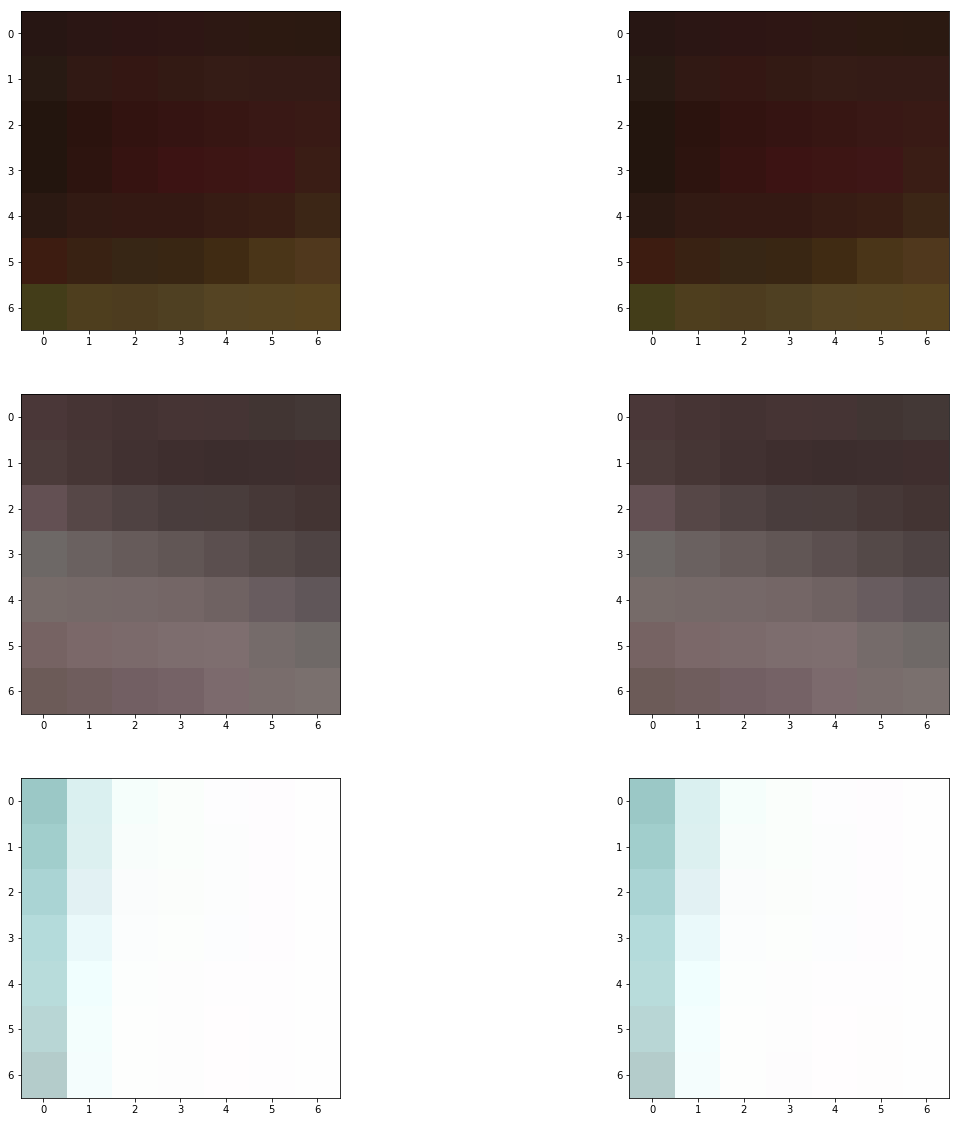

In [19]:
patch_size = 7
offset = int((patch_size - 1) / 2)
loc = np.array([[25, 150, 300],
                [155, 89, 73]])

K_inv = np.linalg.inv(data['K'][:3, :3])

_, gt_p_1 = warp_patch(loc[:,0:1].reshape((1, -1)), gt_H[loc[1, 0], loc[0, 0]], K_inv, data['src0_RGB'], patch_size=7)
our_p_1 = intensities[0, loc[1, 0] - offset, loc[0, 0] - offset] / 255.

_, gt_p_2 = warp_patch(loc[:,1:2].reshape((1, -1)), gt_H[loc[1, 1], loc[0, 1]], K_inv, data['src0_RGB'], patch_size=7)
our_p_2 = intensities[0, loc[1, 1] - offset, loc[0, 1] - offset] / 255.

_, gt_p_3 = warp_patch(loc[:,2:].reshape((1, -1)), gt_H[loc[1, 2], loc[0, 2]], K_inv, data['src0_RGB'], patch_size=7)
our_p_3 = intensities[0, loc[1, 2] - offset, loc[0, 2] - offset] / 255.

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(3, 2, 1)
ax.imshow(gt_p_1)
ax = fig.add_subplot(3, 2, 2)
ax.imshow(our_p_1)
ax = fig.add_subplot(3, 2, 3)
ax.imshow(gt_p_2)
ax = fig.add_subplot(3, 2, 4)
ax.imshow(our_p_2)
ax = fig.add_subplot(3, 2, 5)
ax.imshow(gt_p_3)
ax = fig.add_subplot(3, 2, 6)
ax.imshow(our_p_3)

## Check `compute_patch_difference`

In [20]:
def compute_patch_difference(tgt_img, src_img, K, cam_coords, pred_pose, pred_depth, pred_norm, patch_size=7):
    batch, height, weight, _ = pred_norm.shape

    ## sample tgt patch intensities, [B, 3, H, W, patch_size, patch_size]
    tgt_intensities = tgt_img.unfold(2, patch_size, 1).unfold(3, patch_size, 1)

    ## sample src patch intensities, [B, 3, H, W, patch_size, patch_size]
    src_intensities = sample_src_intensity(src_img, K, cam_coords, pred_pose, pred_depth, pred_norm, patch_size)

    ## patch_difference
    patch_diff = torch.abs(tgt_intensities - src_intensities)
    patch_diff = patch_diff.mean(dim=1, keepdim=True).mean(dim=(4, 5)) # [B, 1, H, W]

    return patch_diff

In [21]:
def check_compute_patch_difference(data, patch_size=7):
    H, W = 240, 320
    patch_size = 7
    
    meshgrid = np.dstack(np.meshgrid(range(W), range(H)))
    meshgrid = homogenize(meshgrid).reshape((-1, 3))
    meshgrid = np.transpose(meshgrid, (1, 0))
    K_inv = np.linalg.inv(data['K'][:3, :3])
    cam_coord = data['depth'].reshape((1, -1)) * (K_inv @ meshgrid)  ## (3, H * W)
    cam_coord = cam_coord.T.reshape((H, W, 3)).astype(np.float32).transpose((2, 0, 1))
    cam_coord_ten = torch.from_numpy(cam_coord[np.newaxis, :, :, :])
    
    normal = torch.from_numpy(data['tgt_norm'][np.newaxis, :, :, :].astype(np.float32).transpose((0, 3, 1, 2)))
    depth = torch.from_numpy(data['depth'][np.newaxis, :, :, np.newaxis].astype(np.float32).transpose((0, 3, 1, 2)))
    pose = torch.from_numpy(data['pose0'][np.newaxis, :, :].astype(np.float32))
    intrinsics = torch.from_numpy(data['K'][np.newaxis, :3, :3].astype(np.float32))
    src_img = torch.from_numpy(data['src0_RGB'][np.newaxis, :, :, :].astype(np.float32).transpose((0, 3, 1, 2)))
    tgt_img = torch.from_numpy(data['tgt_RGB'][np.newaxis, :, :, :].astype(np.float32).transpose((0, 3, 1, 2)))

    
    patch_diff = compute_patch_difference(tgt_img, src_img, intrinsics, cam_coord_ten, pose, depth, normal, patch_size=7)
    patch_diff = patch_diff.numpy().transpose((0, 2, 3, 1)).squeeze()
    return patch_diff

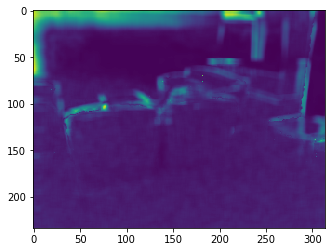

In [22]:
patch_diff = check_compute_patch_difference(data, patch_size=7)
plt.imshow(patch_diff / 255)

### Check dilate

In [23]:
def torch_sample_target_intensity(tgt_img, patch_size=7, dilation=1):
    batch, _, height, width = tgt_img.shape
    unfold = torch.nn.Unfold(kernel_size=(patch_size, patch_size), dilation=dilation)

    ## sample tgt patch intensities, 
    # final resulting `tgt_intensities` has shape [B, 3, H-2*offset, W-2*offset, patch_size, patch_size]
    psize_eff = 1 + dilation * (patch_size - 1) # effective patch size
    ofs = (psize_eff - 1) // 2                  # offset
    tgt_intensities = unfold(tgt_img)       # [B, 3*psize*psize, (H-2*offset)*(W-2*offset)]
    tgt_intensities = tgt_intensities.view(batch, 3, patch_size, patch_size, height-2*ofs, width-2*ofs)
    tgt_intensities = tgt_intensities.permute(0, 1, 4, 5, 2, 3) 
    return tgt_intensities

In [24]:
def check_sample_target_intensity(loc, data, patch_size=3, dilation=2):
    x, y = loc
    psize_eff = 1 + dilation * (patch_size - 1)
    offset = (psize_eff - 1) // 2
    
    tgt_img = torch.from_numpy(data['tgt_RGB'][np.newaxis, :, :, :].astype(np.float32).transpose((0, 3, 1, 2)))
    tgt_intensities = torch_sample_target_intensity(tgt_img, patch_size, dilation)
    
    our_patch = tgt_intensities[0, :, y-offset, x-offset, :, :].numpy().astype(np.uint8)
    our_patch = np.transpose(our_patch, [1, 2, 0])
    
    
    x_s, x_e = x - offset, x + offset
    y_s, y_e = y - offset, y + offset

    gt_patch_eff = data['tgt_RGB'][y_s:y_e+1, x_s:x_e+1, :]
    gt_patch = gt_patch_eff[::dilation, ::dilation, :]
    
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(our_patch)
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(gt_patch)
    
    print("Difference (should be zero): ", np.sum(gt_patch - our_patch))

Difference (should be zero):  0


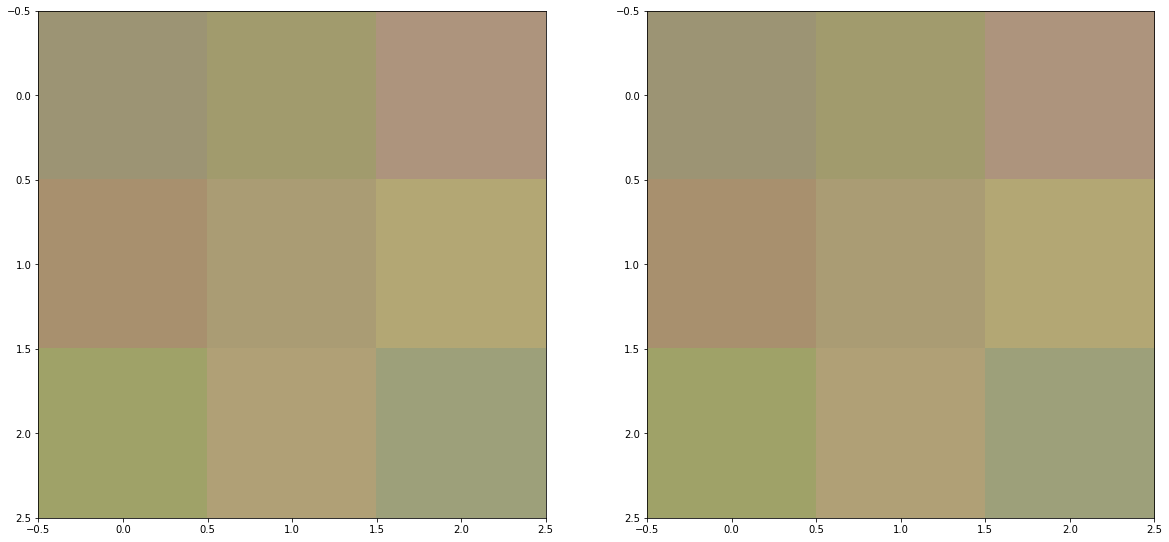

In [25]:
check_sample_target_intensity([2, 2], data, 3, 2)

In [26]:
def sample_src_intensity(src_img, K, cam_coords, pred_pose, pred_depth, pred_norm, patch_size, dilation):
    """Computes src patch intensity
    Input:
        src_img: source image, [B, 3, H, W]
        K: intrinsics, [B, 3, 3]
        cam_coords: backprojected 3D points (K_inv @ x * d), [B, 3, H, W]
        pred_pose: predicted poses, [B, 4, 4]
        pred_depth: predicted depth, [B, 1, H, W]
        pred_norm: predicted surface normal, [B, 3, H, W]
        patch_size: patch size, integer (default = 7)
        dilation: dilation factor for patch (default = 1)
    Output:
        patch_intensities: src patch intensity, [B, 3, H - 2 * offset, W - 2 * offset, patch_size, patch_size]
        (offset = (patch size - 1) / 2)
        patch_coords: patch coordinates [B, 2, (H - 2*offset)*(W - 2*offset), patch_size * patch_size]
    """
    batch, _, height, width = pred_norm.shape
    psize_eff = 1 + dilation * (patch_size - 1) # effective patch size
    offset = (psize_eff - 1) // 2
    
    ## sample src patch intensities
    H = calculate_homography(pred_pose, K, pred_norm, cam_coords) #[B, 3, 3, H, W]

    ## cam_coords = (K_inv @ pts * d) / d 
    cam_coords = cam_coords / pred_depth

    ## get sample grid for each patch
    patch_coords = get_patch_coords(H, cam_coords, patch_size, dilation) #[B, 3, H - 2*offset, W - 2*offset, p_size, p_size]
    pcoords = copy.deepcopy(patch_coords)
    patch_coords = patch_coords.view(batch, 2, -1, patch_size * patch_size)
    patch_coords = patch_coords.permute(0, 2, 3, 1)
    
    ## normalize coordinates from sampling
    patch_coords[..., 0] /= width - 1 
    patch_coords[..., 1] /= height - 1 
    patch_coords = (patch_coords - 0.5) * 2

    ## sample intensity from src img
    patch_intensities = F.grid_sample(src_img, patch_coords, padding_mode='border')
    patch_intensities = patch_intensities.view(batch, 3, height - 2* offset, width - 2* offset, patch_size, patch_size)
    
    return patch_intensities, pcoords

def get_patch_coords(H, cam_coords, patch_size, dilation):
    """ Get the src patch coordinates 
    Input:
        H:  K(R - tn^T/d), [B, 3, 3, H, W]
        cam_coords: backprojected 3D points / d (K_inv @ x), [B, 3, H, W]
        patch_size: patch size, integer (default = 7)
        dilation: dilation factor for patch (default = 1)
    Output:
        patch_coords: sample idx for each patch, [B, 2, H - 2 * offset, W - 2 * offset, patch_size, patch_size] 
        (offset = (patch size - 1) / 2)
    """
    batch, _, height, width = cam_coords.shape
    psize_eff = 1 + dilation * (patch_size - 1) # effective patch size
    offset = (psize_eff - 1) // 2               # offset

    unfold = torch.nn.Unfold(kernel_size=(patch_size, patch_size), dilation=dilation)
    patch_coords = unfold(cam_coords) # # [B, 3*psize*psize, (H-2*offset)*(W-2*offset)]
    patch_coords = patch_coords.view(batch, 3, patch_size, patch_size, height-2*offset, width-2*offset)
    patch_coords = patch_coords.permute(0, 1, 4, 5, 2, 3) #[B, 3, H, W, patch_size, patch_size]
    H = H[:, :, :, offset:-offset, offset:-offset]
    
    patch_coords = torch.einsum("mnpqr, mpqrst -> mnqrst", H, patch_coords) #[B, 3, H, W, patch_size, patch_size]
    patch_coords = patch_coords[:, :2, :, :, :, :] / (patch_coords[:, 2:, :, :, :, :] + 1e-10) # dehomogenize
    return patch_coords

def calculate_homography(pose, K, pred_norm, cam_coords):
    """Computes the homography of each pixel 
    Input:
        K: intrinsics, [B, 3, 3]
        cam_coords: backprojected 3D points (K_inv @ x * d), [B, 3, H, W]
        pred_pose: predicted poses, [B, 4, 4]
        pred_norm: predicted surface normal, [B, 3, H, W]
    Output:
        H: sample idx for each patch, [B, 3, 3, H, W] 
    """
    B, _, H, W = pred_norm.shape

    # compute d = - (nx*x + ny*y + nz*z), [B, 1, H, W]
    d = torch.sum(pred_norm * cam_coords, dim=1, keepdim=True) * -1

    # construct homography matrix H = (R - tn^T/d), [B, 3, H, W]
    scaled_norm = pred_norm / (d + 1e-10)

    R = pose[:, :3, :3].view(B, 3, 3)
    t = pose[:, :3, 3].view(B, 3)
    R = torch.unsqueeze(torch.unsqueeze(R, -1), -1) # [B, 3, 3, 1, 1]
    R = R.repeat(1, 1, 1, H, W)
    
    # outer product: outer[m, q, n, p, r] = t[m, q] * scaled_norm[m, n, p, r]
    outer = torch.einsum('mq, mnpr -> mqnpr', t, scaled_norm)
    H = R - outer # [B, 3, 3, H, W]

    # pre-multiply with K, H = K(R - tn^T/d)
    H = torch.einsum('bcd, bdehw -> bcehw', K, H)

    return H

In [27]:
def checkSampleSrcIntensity(data):
    H, W = 240, 320
    patch_size = 3
    dilation = 2
    
    meshgrid = np.dstack(np.meshgrid(range(W), range(H)))
    meshgrid = homogenize(meshgrid).reshape((-1, 3))
    meshgrid = np.transpose(meshgrid, (1, 0))
    K_inv = np.linalg.inv(data['K'][:3, :3])
    cam_coord = data['depth'].reshape((1, -1)) * (K_inv @ meshgrid)  ## (3, H * W)
    cam_coord = cam_coord.T.reshape((H, W, 3)).astype(np.float32).transpose((2, 0, 1))
    cam_coord_ten = torch.from_numpy(cam_coord[np.newaxis, :, :, :])
    
    normal = torch.from_numpy(data['tgt_norm'][np.newaxis, :, :, :].astype(np.float32).transpose((0, 3, 1, 2)))
    depth = torch.from_numpy(data['depth'][np.newaxis, :, :, np.newaxis].astype(np.float32).transpose((0, 3, 1, 2)))
    pose = torch.from_numpy(data['pose0'][np.newaxis, :, :].astype(np.float32))
    intrinsics = torch.from_numpy(data['K'][np.newaxis, :3, :3].astype(np.float32))
    src_img = torch.from_numpy(data['src0_RGB'][np.newaxis, :, :, :].astype(np.float32).transpose((0, 3, 1, 2)))
    
    intensities, pcoords = sample_src_intensity(src_img, intrinsics, cam_coord_ten, pose, depth, normal, patch_size, dilation)
    intensities = intensities.permute(0, 2, 3, 4, 5, 1).numpy()
    return intensities, pcoords

In [28]:
def ssim_patch(x, y):
    """Computes the patch SSIM loss
        Input:
        x: [B, 3, H, W, patch_size, patch_size]
        y: [B, 3, H, W, patch_size, patch_size]
        Output:
        SSIM: SSIM of all patches, [B, 1, H, W]
    """
    C1, C2 = 0.01 ** 2, 0.03 ** 2
    B, _, H, W, size, _ = x.shape
    x = x.contiguous().view(B, 3, H, W, size * size)
    y = y.contiguous().view(B, 3, H, W, size * size)

    mu_x = torch.mean(x, dim=4)
    mu_y = torch.mean(y, dim=4)

    sig_x = torch.mean(x ** 2, dim=4) - mu_x ** 2
    sig_y = torch.mean(y ** 2, dim=4) - mu_y ** 2
    sig_xy = torch.mean(x * y, dim=4) - mu_x * mu_y

    SSIM_n = (2 * mu_x * mu_y + C1) * (2 * sig_xy + C2)
    SSIM_d = (mu_x ** 2 + mu_y ** 2 + C1) * (sig_x + sig_y + C2) + 1e-10
    SSIM = torch.clamp((1 - SSIM_n / SSIM_d) / 2, 0, 1)

    SSIM = torch.mean(SSIM, dim=1, keepdim=True)
    return SSIM

def compute_patch_difference(tgt_img, src_img, K, cam_coords,
                             pred_pose, pred_depth, pred_norm,
                             patch_size=7, dilation=1, type="median"):
    """Computes the patch intensity difference between tgt and src
    Input:
        tgt_img: target image, [B, 3, H, W]
        src_img: source image, [B, 3, H, W]
        K: intrinsics, [B, 4, 4]
        cam_coords: backprojected 3D points (K_inv @ x * d), [B, 4, H * W]
        pred_pose: predicted poses, [B, 4, 4]
        pred_depth: predicted depth, [B, 1, H, W]
        pred_norm: predicted surface normal, [B, 3, H, W]
        patch_size: patch size, integer (default = 7)
        dilation: dilation factor for patch (default = 1)
    Output:
        patch_diff: patch intensity difference, value in each pixel indicates max/average intensity 
        difference for that patch. [B, 1, H, W]
    """
    batch, _, height, width = pred_norm.shape
    cam_coords = cam_coords[:, :-1, :].view(batch, 3, height, width)
    K = K[:, :3, :3]

    unfold = torch.nn.Unfold(kernel_size=(patch_size, patch_size), dilation=dilation)

    ## sample tgt patch intensities, 
    # final resulting `tgt_intensities` has shape [B, 3, H-2*offset, W-2*offset, patch_size, patch_size]
    psize_eff = 1 + dilation * (patch_size - 1) # effective patch size
    ofs = (psize_eff - 1) // 2                  # offset
    tgt_intensities = unfold(tgt_img)       # [B, 3*psize*psize, (H-2*offset)*(W-2*offset)]
    tgt_intensities = tgt_intensities.view(batch, 3, patch_size, patch_size, height-2*ofs, width-2*ofs)
    tgt_intensities = tgt_intensities.permute(0, 1, 4, 5, 2, 3) 

    ## sample src patch intensities, [B, 3, H - 2 * offset, W - 2 * offset, patch_size, patch_size]
    src_intensities, src_coords = sample_src_intensity(src_img, K, cam_coords, pred_pose, pred_depth, pred_norm, patch_size, dilation)

    ## patch_difference
    if type == "mean":
        patch_abs = torch.abs(tgt_intensities - src_intensities).mean(dim=1, keepdim=True).mean(dim=(4, 5)) # [B, 1, H - 2*offset, W - 2*offset]
    else:
        patch_abs = torch.abs(tgt_intensities - src_intensities).mean(dim=1, keepdim=True)
        patch_abs = patch_abs.view(batch, 1, height-2*ofs, width-2*ofs, -1) # [B, 1, H-2*offset, W-2*offset, patch_size * patch_size]
        if type == "max":
            patch_abs, _ = patch_abs.max(dim=-1) # [B, 1, H-2*offset, W-2*offset]
        elif type == "median":
            patch_abs, _ = patch_abs.median(dim=-1)
        else:
            raise ValueError("Operation type not recognized.")

    patch_diff = patch_abs * 0.15 + ssim_patch(tgt_intensities, src_intensities) * 0.85

    return patch_diff, src_coords

def compare_patch_difference(data, fake_norm):
    H, W = 240, 320
    patch_size = 3
    dilation = 2
    
    meshgrid = np.dstack(np.meshgrid(range(W), range(H)))
    meshgrid = homogenize(meshgrid).reshape((-1, 3))
    meshgrid = np.transpose(meshgrid, (1, 0))
    K_inv = np.linalg.inv(data['K'][:3, :3])
    cam_coord = data['depth'].reshape((1, -1)) * (K_inv @ meshgrid)  ## (3, H * W)
    cam_coord = cam_coord.T.reshape((H, W, 3)).astype(np.float32).transpose((2, 0, 1))
    cam_coord = np.concatenate([cam_coord, np.ones([1, H, W])], axis=0).astype(np.float32)
    cam_coord_ten = torch.from_numpy(cam_coord[np.newaxis, :, :, :])
    
    fake_norm = torch.from_numpy(fake_norm[np.newaxis, :, :, :].astype(np.float32).transpose((0, 3, 1, 2)))
    normal = torch.from_numpy(data['tgt_norm'][np.newaxis, :, :, :].astype(np.float32).transpose((0, 3, 1, 2)))
    depth = torch.from_numpy(data['depth'][np.newaxis, :, :, np.newaxis].astype(np.float32).transpose((0, 3, 1, 2)))
    pose = torch.from_numpy(data['pose0'][np.newaxis, :, :].astype(np.float32))
    intrinsics = torch.from_numpy(data['K'][np.newaxis, :3, :3].astype(np.float32))
    src_img = torch.from_numpy(data['src0_RGB'][np.newaxis, :, :, :].astype(np.float32).transpose((0, 3, 1, 2))) / 255.0
    tgt_img = torch.from_numpy(data['tgt_RGB'][np.newaxis, :, :, :].astype(np.float32).transpose((0, 3, 1, 2))) / 255.0
    
    loss_gt, _ = compute_patch_difference(tgt_img, src_img,
                                       intrinsics, cam_coord_ten, pose, 
                                       depth, normal, patch_size=5, dilation=2, type="max")
    loss_fk, _ = compute_patch_difference(tgt_img, src_img,
                                       intrinsics, cam_coord_ten, pose, 
                                       depth, fake_norm, patch_size=5, dilation=2, type="max")
    return loss_gt, loss_fk

def visualize_patches(data, intensities, pcoords, gt_H):
    patch_size = 3
    dilation = 2
    patch_size_eff = 1 + dilation * (patch_size - 1)
    offset = int((patch_size_eff - 1) / 2)
    loc = np.array([[25, 150, 300],
                    [155, 89, 73]])

    K_inv = np.linalg.inv(data['K'][:3, :3])

    ps1, gt_p_1 = warp_patch(loc[:,0:1].reshape((1, -1)), gt_H[loc[1, 0], loc[0, 0]], K_inv, data['src0_RGB'], patch_size=patch_size_eff)
    gt_p_1 = gt_p_1[::dilation, ::dilation, :]
    our_p_1 = intensities[0, loc[1, 0] - offset, loc[0, 0] - offset] / 255.
    print('Numpy patch coordinates:')
    print(ps1[:,  :])
    print('Pytorch patch coordinates:')
    print(pcoords[0, :, loc[1, 0] - offset, loc[0, 0] - offset])
    print('-'*50)
    
    _, gt_p_2 = warp_patch(loc[:,1:2].reshape((1, -1)), gt_H[loc[1, 1], loc[0, 1]], K_inv, data['src0_RGB'], patch_size=patch_size_eff)
    gt_p_2 = gt_p_2[::dilation, ::dilation, :]
    our_p_2 = intensities[0, loc[1, 1] - offset, loc[0, 1] - offset] / 255.

    _, gt_p_3 = warp_patch(loc[:,2:].reshape((1, -1)), gt_H[loc[1, 2], loc[0, 2]], K_inv, data['src0_RGB'], patch_size=patch_size_eff)
    gt_p_3 = gt_p_3[::dilation, ::dilation, :]
    our_p_3 = intensities[0, loc[1, 2] - offset, loc[0, 2] - offset] / 255.


    template = 'Patch {} Diff = {}'
    print(template.format(1, np.mean(np.abs(gt_p_1 - our_p_1))))
    print(template.format(2, np.mean(np.abs(gt_p_2 - our_p_2))))
    print(template.format(3, np.mean(np.abs(gt_p_3 - our_p_3))))

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(3, 2, 1)
    ax.imshow(gt_p_1)
    ax = fig.add_subplot(3, 2, 2)
    ax.imshow(our_p_1)
    ax = fig.add_subplot(3, 2, 3)
    ax.imshow(gt_p_2)
    ax = fig.add_subplot(3, 2, 4)
    ax.imshow(our_p_2)
    ax = fig.add_subplot(3, 2, 5)
    ax.imshow(gt_p_3)
    ax = fig.add_subplot(3, 2, 6)
    ax.imshow(our_p_3)

In [29]:
intensities, pcoords = checkSampleSrcIntensity(data)

Numpy patch coordinates:
[[  6.41434123   7.41663649   8.41862057   9.42029362  10.42165578
    6.45637703   7.45834253   8.45999704   9.46134072  10.46237371
    6.49838573   7.50002167   8.50134683   9.50236136  10.5030654
    6.54036735   7.54167394   8.54266997   9.54335556  10.54373087
    6.58232191   7.58329938   8.58396648   9.58432336  10.58437015]
 [123.30201828 123.32957905 123.35713127 123.38467494 123.41221005
  124.26601204 124.29341431 124.32080807 124.34819333 124.3755701
  125.22938411 125.25662807 125.28386358 125.31109063 125.33830925
  126.1921351  126.21922095 126.24629839 126.27336744 126.3004281
  127.1542656  127.18119354 127.20811312 127.23502436 127.26192726]]
Pytorch patch coordinates:
tensor([[[  6.4143,   8.4186,  10.4216],
         [  6.4984,   8.5014,  10.5031],
         [  6.5823,   8.5840,  10.5844]],

        [[123.3020, 123.3571, 123.4122],
         [125.2294, 125.2839, 125.3383],
         [127.1543, 127.2081, 127.2619]]])
----------------------------

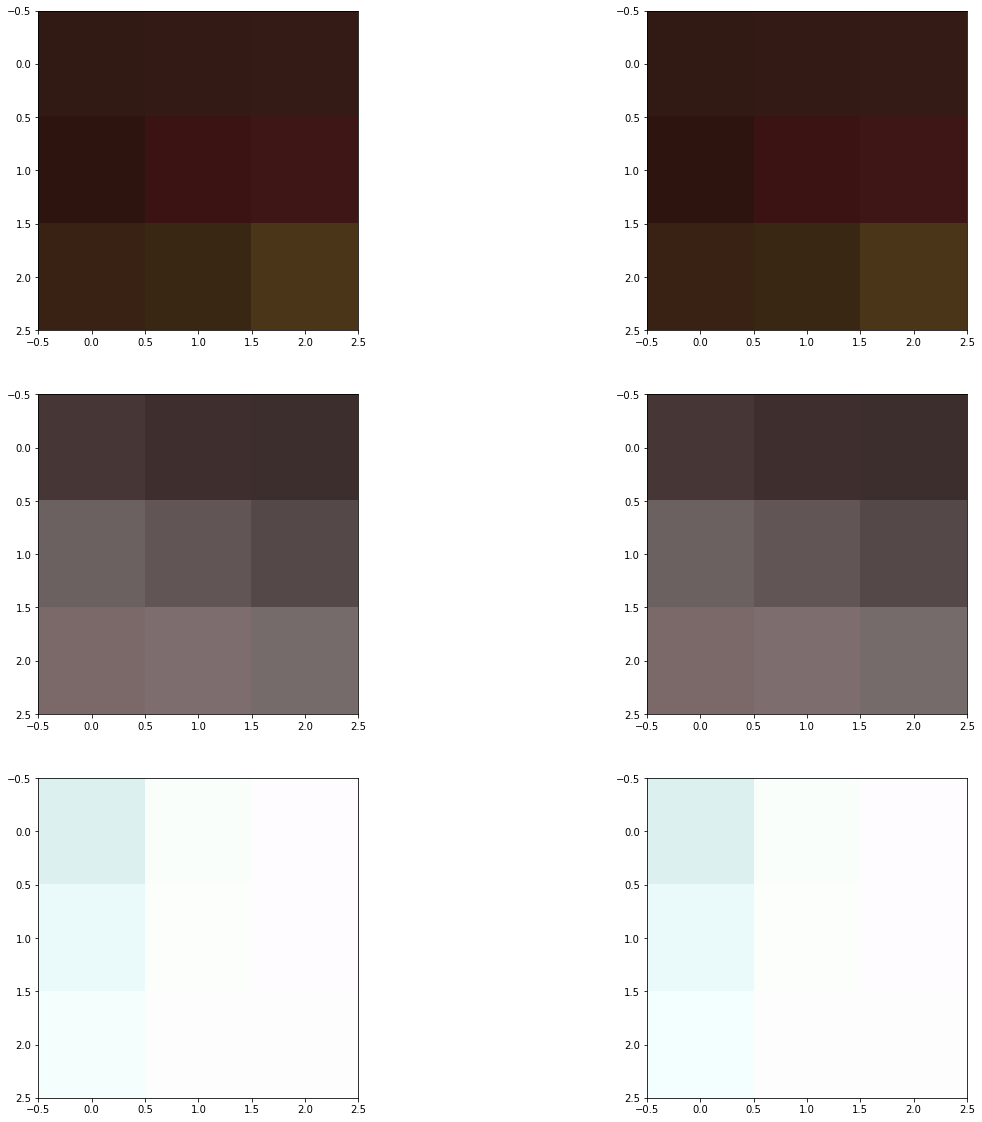

In [30]:
visualize_patches(data, intensities, pcoords, gt_H)

### Case: Normal at -z direction

In [31]:
ones = np.ones([H, W])
zeros = np.zeros([H, W])
fake_normal = np.dstack([zeros, zeros, -ones])

In [32]:
data_copy = copy.deepcopy(data)
data_copy['tgt_norm'] = fake_normal
intensities_fake, pcoords_fake = checkSampleSrcIntensity(data_copy)

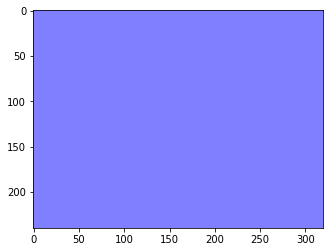

In [33]:
plt.imshow(plot_normal(data_copy['tgt_norm']))
plt.show()

NUMPY PATCH COORDINATES ARE COMPUTED WITH GT NORMAL
 WHEREAS PYTORCH ONES ARE WITH FAKE NORMAL!


Numpy patch coordinates:
[[  6.41434123   7.41663649   8.41862057   9.42029362  10.42165578
    6.45637703   7.45834253   8.45999704   9.46134072  10.46237371
    6.49838573   7.50002167   8.50134683   9.50236136  10.5030654
    6.54036735   7.54167394   8.54266997   9.54335556  10.54373087
    6.58232191   7.58329938   8.58396648   9.58432336  10.58437015]
 [123.30201828 123.32957905 123.35713127 123.38467494 123.41221005
  124.26601204 124.29341431 124.32080807 124.34819333 124.3755701
  125.22938411 125.25662807 125.28386358 125.31109063 125.33830925
  126.1921351  126.21922095 126.24629839 126.27336744 126.3004281
  127.1542656  127.18119354 127.20811312 127.23502436 127.26192726]]
Pytorch patch coordinates:
tensor([[[  6.4145,   8.4603,  10.5040],
         [  6.4565,   8.5014,  10.5441],
         [  6.4985,   8.5424,  10.5842]],

        [[123.3019, 123.3175, 123.3330],
         [125.

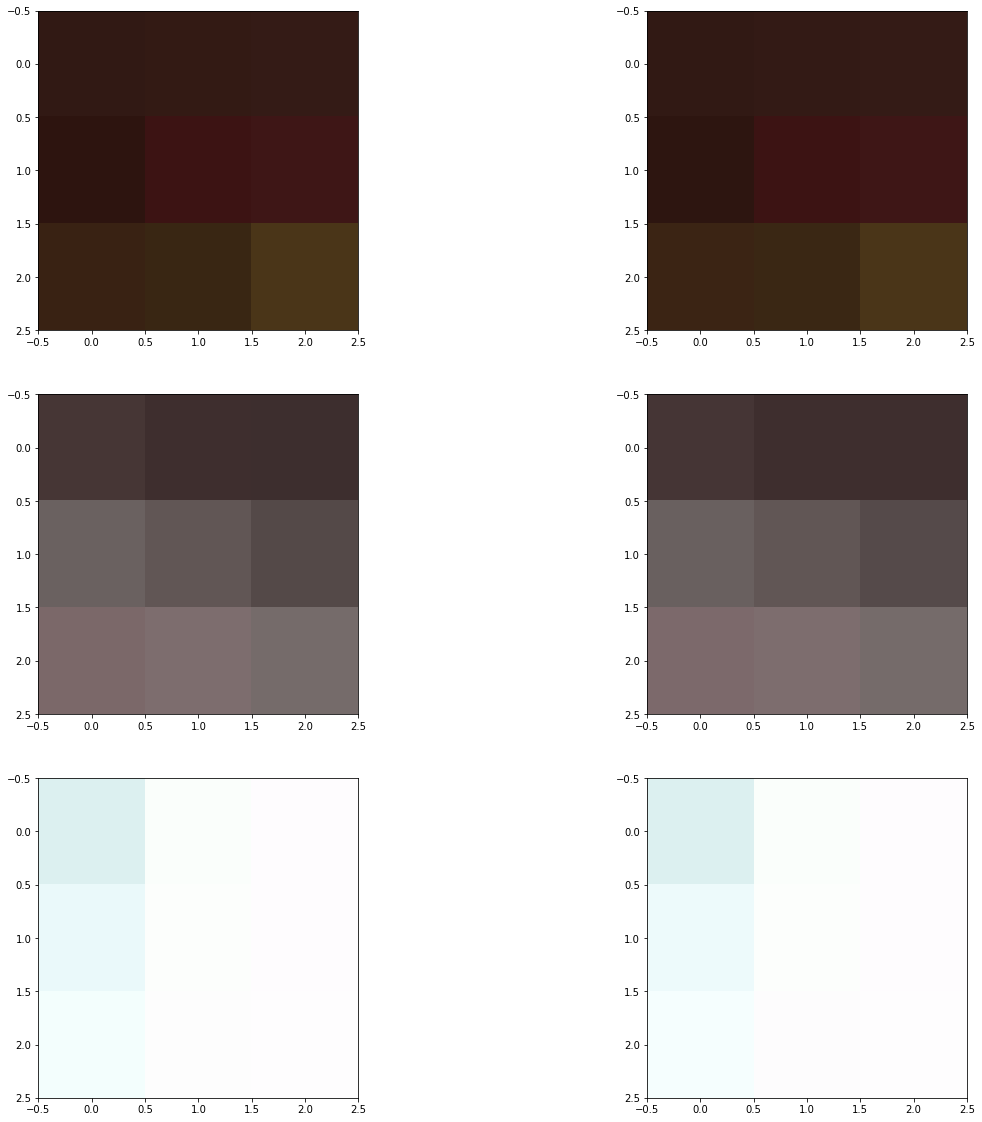

In [34]:
print('NUMPY PATCH COORDINATES ARE COMPUTED WITH GT NORMAL\n WHEREAS PYTORCH ONES ARE WITH FAKE NORMAL!\n\n')
visualize_patches(data, intensities_fake, pcoords_fake, gt_H)

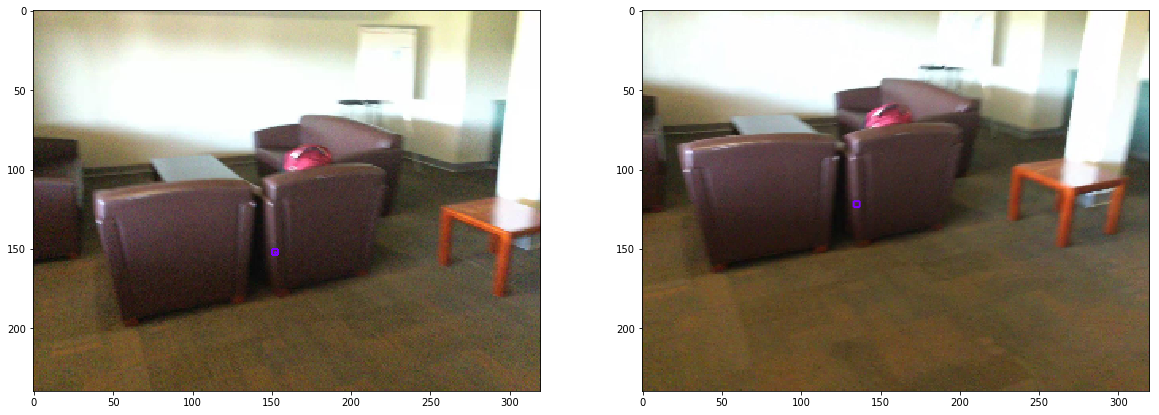

In [35]:
patch_centers=np.array([[152], [152]])
_, n_pts = patch_centers.shape
ofs = 2
patch_coords = pcoords_fake

color=cm.rainbow(np.linspace(0, 1, n_pts))
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(data['tgt_RGB'])
ax2.imshow(data['src0_RGB'])
for i, c in zip(range(n_pts), color):
    ctr_x, ctr_y = patch_centers[:, i].astype(int)

    # plot patch centers on target image
    ax1.scatter(ctr_x, ctr_y, color=c, s=4)

    # plot patch boundaries on target image
    upper_left  = (ctr_x-ofs, ctr_y-ofs)
    upper_right = (ctr_x+ofs, ctr_y-ofs)
    lower_left =  (ctr_x-ofs, ctr_y+ofs)
    lower_right = (ctr_x+ofs, ctr_y+ofs)
    lines = [[upper_left, upper_right], 
            [upper_right, lower_right],
            [lower_right, lower_left],
            [lower_left, upper_left]]
    lc = mc.LineCollection(lines, colors=c, linewidths=2)
    ax1.add_collection(lc)

    # plot patch centers on source image
#     ctr_x_s, ctr_s_y = pixel_coords[0, :, ctr_y, ctr_x]
#     ax2.scatter(ctr_x_s, ctr_s_y, color=c, s=4)

    # plot patch boundaries on source image
    ctr_x -= ofs
    ctr_y -= ofs
    coord = patch_coords[0, :, ctr_y, ctr_x, :, :].numpy() # [2, patch_size, patch_size]

    # for plotting lines, refer to 
    # https://stackoverflow.com/questions/21352580/matplotlib-plotting-numerous-disconnected-line-segments-with-different-colors
    upper_left  = coord[:,  0,  0]
    upper_right = coord[:,  0, -1]
    lower_left  = coord[:, -1,  0]
    lower_right = coord[:, -1, -1]
    lines = [[upper_left, upper_right], 
            [upper_right, lower_right],
            [lower_right, lower_left],
            [lower_left, upper_left]]
    lc = mc.LineCollection(lines, colors=c, linewidths=2)
    ax2.add_collection(lc)
plt.show()

In [36]:
# calculate loss
loss_gt, loss_fk = compare_patch_difference(data, fake_normal)

loss_fk_mean = torch.mean(loss_fk, dim=(2, 3))
loss_gt_mean = torch.mean(loss_gt, dim=(2, 3))
print(loss_fk_mean)
print(loss_gt_mean)
print(loss_gt_mean - loss_fk_mean)

tensor([[0.1253]])
tensor([[0.1255]])
tensor([[0.0002]])


### Case Normal at -x direction

In [37]:
del data_copy, intensities_fake, fake_normal

In [38]:
ones = np.ones([H, W])
zeros = np.zeros([H, W])
fake_normal = np.dstack([-ones, zeros, zeros])

In [39]:
data_copy = copy.deepcopy(data)
data_copy['tgt_norm'] = fake_normal
intensities_fake, pcoords_fake = checkSampleSrcIntensity(data_copy)

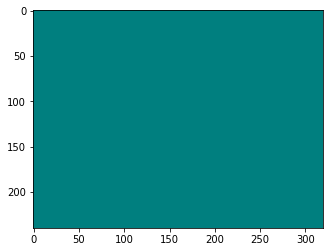

In [40]:
plt.imshow(plot_normal(data_copy['tgt_norm']))
plt.show()

NUMPY PATCH COORDINATES ARE COMPUTED WITH GT NORMAL
 WHEREAS PYTORCH ONES ARE WITH FAKE NORMAL!


Numpy patch coordinates:
[[  6.41434123   7.41663649   8.41862057   9.42029362  10.42165578
    6.45637703   7.45834253   8.45999704   9.46134072  10.46237371
    6.49838573   7.50002167   8.50134683   9.50236136  10.5030654
    6.54036735   7.54167394   8.54266997   9.54335556  10.54373087
    6.58232191   7.58329938   8.58396648   9.58432336  10.58437015]
 [123.30201828 123.32957905 123.35713127 123.38467494 123.41221005
  124.26601204 124.29341431 124.32080807 124.34819333 124.3755701
  125.22938411 125.25662807 125.28386358 125.31109063 125.33830925
  126.1921351  126.21922095 126.24629839 126.27336744 126.3004281
  127.1542656  127.18119354 127.20811312 127.23502436 127.26192726]]
Pytorch patch coordinates:
tensor([[[  6.5570,   8.4603,  10.3641],
         [  6.5989,   8.5014,  10.4044],
         [  6.6408,   8.5424,  10.4445]],

        [[123.1675, 123.3175, 123.4675],
         [125.

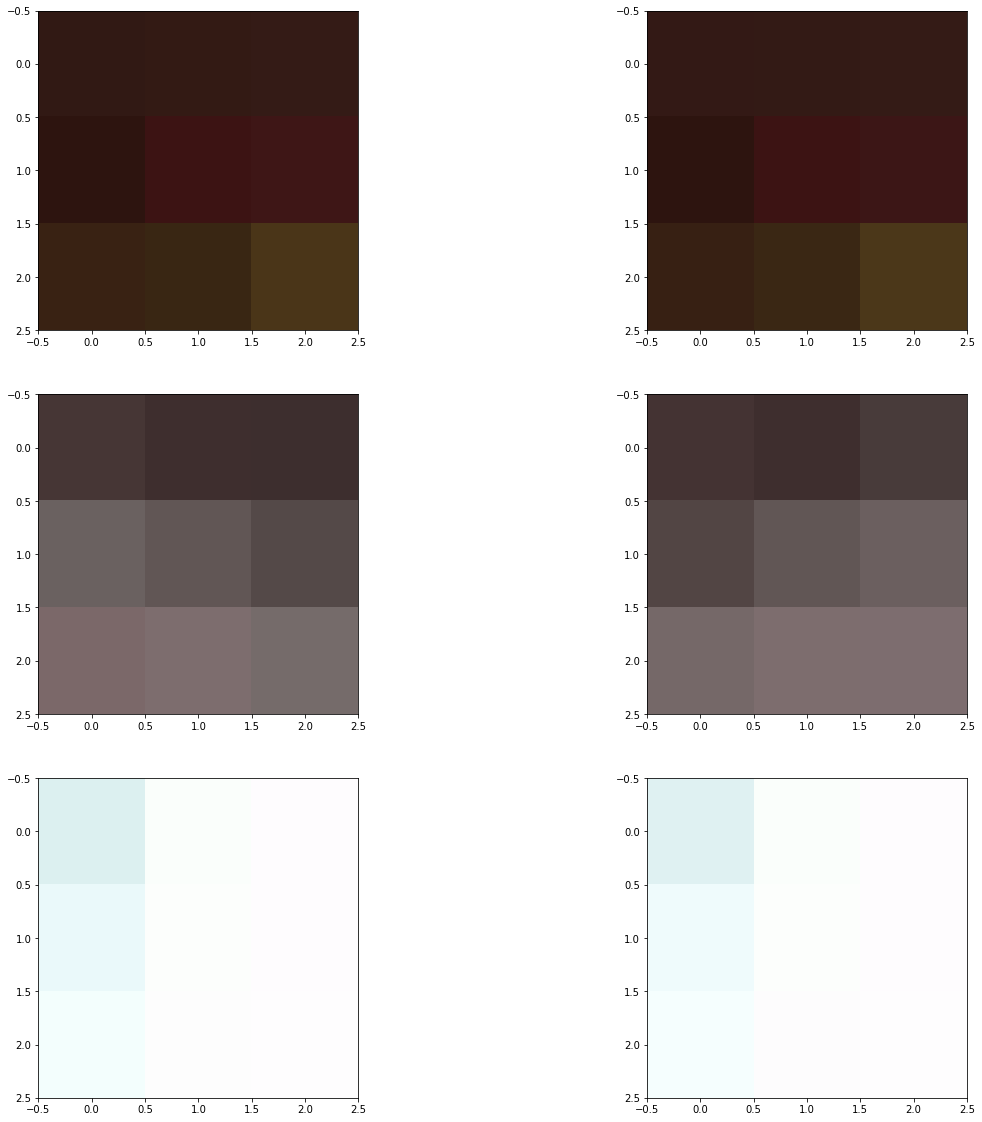

In [41]:
print('NUMPY PATCH COORDINATES ARE COMPUTED WITH GT NORMAL\n WHEREAS PYTORCH ONES ARE WITH FAKE NORMAL!\n\n')
visualize_patches(data, intensities_fake, pcoords_fake, gt_H)

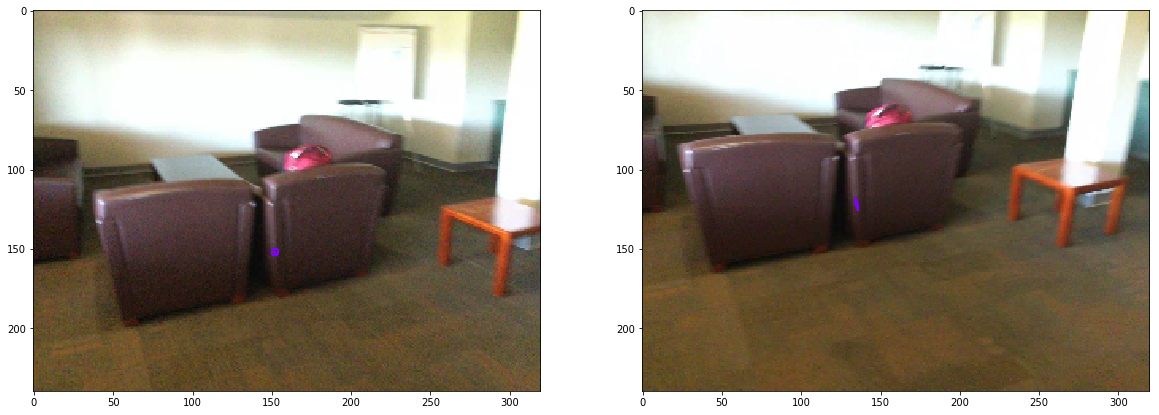

In [42]:
patch_centers=np.array([[152], [152]])
_, n_pts = patch_centers.shape
ofs = 2
patch_coords = pcoords_fake

color=cm.rainbow(np.linspace(0, 1, n_pts))
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(data['tgt_RGB'])
ax2.imshow(data['src0_RGB'])
for i, c in zip(range(n_pts), color):
    ctr_x, ctr_y = patch_centers[:, i].astype(int)

    # plot patch centers on target image
    ax1.scatter(ctr_x, ctr_y, color=c, s=4)

    # plot patch boundaries on target image
    upper_left  = (ctr_x-ofs, ctr_y-ofs)
    upper_right = (ctr_x+ofs, ctr_y-ofs)
    lower_left =  (ctr_x-ofs, ctr_y+ofs)
    lower_right = (ctr_x+ofs, ctr_y+ofs)
    lines = [[upper_left, upper_right], 
            [upper_right, lower_right],
            [lower_right, lower_left],
            [lower_left, upper_left]]
    lc = mc.LineCollection(lines, colors=c, linewidths=2)
    ax1.add_collection(lc)

    # plot patch centers on source image
#     ctr_x_s, ctr_s_y = pixel_coords[0, :, ctr_y, ctr_x]
#     ax2.scatter(ctr_x_s, ctr_s_y, color=c, s=4)

    # plot patch boundaries on source image
    ctr_x -= ofs
    ctr_y -= ofs
    coord = patch_coords[0, :, ctr_y, ctr_x, :, :].numpy() # [2, patch_size, patch_size]

    # for plotting lines, refer to 
    # https://stackoverflow.com/questions/21352580/matplotlib-plotting-numerous-disconnected-line-segments-with-different-colors
    upper_left  = coord[:,  0,  0]
    upper_right = coord[:,  0, -1]
    lower_left  = coord[:, -1,  0]
    lower_right = coord[:, -1, -1]
    lines = [[upper_left, upper_right], 
            [upper_right, lower_right],
            [lower_right, lower_left],
            [lower_left, upper_left]]
    lc = mc.LineCollection(lines, colors=c, linewidths=2)
    ax2.add_collection(lc)
plt.show()

In [43]:
# calculate loss
loss_gt, loss_fk = compare_patch_difference(data, fake_normal)

loss_fk_mean = torch.mean(loss_fk, dim=(2, 3))
loss_gt_mean = torch.mean(loss_gt, dim=(2, 3))
print(loss_fk_mean)
print(loss_gt_mean)
print(loss_gt_mean - loss_fk_mean)

tensor([[0.1389]])
tensor([[0.1255]])
tensor([[-0.0134]])
